# Prototyping CNN Models For Language Classification
#### By: Bowen Zhang

## Overview
The goal of this project is to try and classify different languages based on audio signals from speech. We will be using mel-spectrograms to capture those signals from voice recordings and then perform an image classification on those mel-spectrograms to determine the language classes. This is the process of trying different CNN model architectures and trying to tune the hyperparameters to achieve the final model code. Data used for training the models were collected from [Voxforge](http://www.voxforge.org/) which is an online repository of user submitted audio clips in various languages. 

**NOTE:** Depending on your GPU and video memory size, you may not be able to reproduce these results by just running all these models in one go. You may have to clear the kernel and gpu memory everytime you run a different model or you may get an error or the model with run without gradients being calculated if memory is maxed out. This seems to be an issue with juypter, but I have not tried it on any other platforms such as Google Colab, etc. Below are the specs of my computer which this notebook was ran with. Your experience may vary.

In [15]:
# get PC specs
%watermark -v -m -p numpy,pandas,matplotlib,sklearn,librosa,torch

CPython 3.8.5
IPython 7.16.1

numpy 1.19.1
pandas 1.0.5
matplotlib 3.2.2
sklearn 0.23.2
librosa 0.6.3
torch 1.6.0

compiler   : MSC v.1916 64 bit (AMD64)
system     : Windows
release    : 10
machine    : AMD64
processor  : Intel64 Family 6 Model 158 Stepping 9, GenuineIntel
CPU cores  : 8
interpreter: 64bit


## Table of Contents

1. [Loading In The Data](#load) <br>
    1.1 [Train/Validation Split](#split)
2. [Models](#models) <br>
    2.1 [First Model - Static CNN](#firstmodel) <br>
    2.2 [Second Model - Expanding CNN](#secondmodel) <br>
    2.3 [Third Model - Batch Norm + Dropout](#thirdmodel) <br>
3. [Hyperparameter Optimization](#optparam) <br>
    3.1 [First Version](#firstver) <br>
    3.2 [Second Version](#secondver) <br>
    3.3 [Third Version](#thirdver) <br>
    3.4 [Results](#results) <br>
4. [Early Stopping](#earlystop) <br>
    4.1 [Baseline Model](#baseline) <br>
    4.2 [Second Optimized Model](#optmod2) <br>
    4.3 [Third Optimized Model](#optmod3) <br>
5. [Conclusion](#conclusion)

<a id="load"></a>
## Loading in the Data

Let's load in our data. First let's make sure we have all the correct classes in our data folder.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import torch
import torchvision
import torchvision.transforms as tf

from torch.utils.data import random_split
from torchvision.datasets import ImageFolder
from torch.utils.data.dataloader import DataLoader

from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

In [2]:
# see our classes
classes = os.listdir(path="data/train/")
print(classes)

['English', 'French', 'German', 'Italian', 'Spanish']


That looks correct. Now let's load in all our data for both the train and test sets and perform the necessary transformations to them. We will reshape them to 64x64 pixels and transform them to tensors for our deep learning purposes.

In [3]:
# import our data set and convert to tensors
transformations = tf.Compose([tf.Resize([64,64]), tf.ToTensor()]) # our transformations when importing the images

trainset = ImageFolder('data/train', transform=transformations)
testset = ImageFolder('data/test', transform=transformations)

Now that we have loaded in our training and test data that we created with our bash/python scripts from earlier, let's take a look at what an image looks like.

In [4]:
img, label = trainset[0]
print(img.shape, label)
img

torch.Size([3, 64, 64]) 0


tensor([[[0.6157, 0.5216, 0.4902,  ..., 0.6235, 0.5529, 0.3882],
         [0.8118, 0.6980, 0.6588,  ..., 0.7647, 0.7373, 0.5569],
         [0.8941, 0.7569, 0.6863,  ..., 0.7804, 0.7608, 0.5569],
         ...,
         [0.9882, 0.9647, 0.9647,  ..., 0.9804, 0.9843, 0.9843],
         [0.9882, 0.9882, 0.9882,  ..., 0.9843, 0.9843, 0.9882],
         [0.9882, 0.9882, 0.9882,  ..., 0.9922, 0.9882, 0.9922]],

        [[0.1843, 0.1529, 0.1373,  ..., 0.1843, 0.1647, 0.1020],
         [0.2706, 0.2118, 0.1961,  ..., 0.2353, 0.2275, 0.1647],
         [0.3294, 0.2353, 0.2039,  ..., 0.2392, 0.2353, 0.1647],
         ...,
         [0.6745, 0.5373, 0.5020,  ..., 0.5176, 0.5333, 0.5373],
         [0.8902, 0.8039, 0.7765,  ..., 0.5490, 0.5490, 0.6118],
         [0.9490, 0.9255, 0.9059,  ..., 0.8196, 0.8431, 0.8471]],

        [[0.4941, 0.5020, 0.5020,  ..., 0.4941, 0.5020, 0.4941],
         [0.4275, 0.4706, 0.4863,  ..., 0.4510, 0.4588, 0.4902],
         [0.3961, 0.4588, 0.4824,  ..., 0.4510, 0.4549, 0.

As we expected, the raw image data is a just a bunch of arrays! Let's check that we have loaded in the correct classes for both the train and test sets:

In [5]:
print(testset.classes)
print(trainset.classes)

['English', 'French', 'German', 'Italian', 'Spanish']
['English', 'French', 'German', 'Italian', 'Spanish']


The classes look good. For a final sanity check, let's visualize some of of the images (not in tensor form anymore):

In [6]:
def show_example(img, label):
    print('Label: ', trainset.classes[label], "("+str(label)+")")
    plt.imshow(img.permute(1, 2, 0))

Label:  English (0)


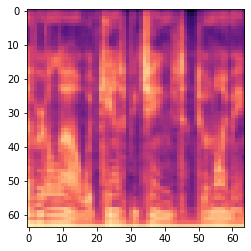

In [7]:
show_example(*trainset[0])

Label:  English (0)


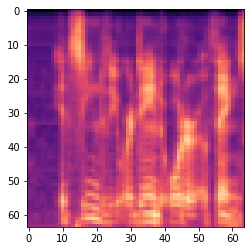

In [8]:
show_example(*testset[0])

_______________________________________________________________________________

<a id="split"></a>
## Training, Validation Sets

Looks like we have loaded in our data successfully. Now let's split our training set into train and validation sets. We will do a 80/20 split respectively. 

In [9]:
# set seed for reproducibility
random_seed = 10
torch.manual_seed(random_seed)

In [10]:
# train - validation split with validation being 20% of training data
val_size = int(len(trainset)*0.20)
train_size = len(trainset) - val_size

train_ds, val_ds = random_split(trainset, [train_size, val_size])
len(train_ds), len(val_ds)

(31500, 7875)

In [11]:
# set our batch size and intialize our data loader to feed batches into the model
batch_size=64

train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4)
val_dl = DataLoader(val_ds, batch_size*2, num_workers=4)

We have now set up our data loaders to load batches of 64 images into the model for training. For a quick sanity check, let's visualize what a batch of images looks like:

In [12]:
from torchvision.utils import make_grid

# preview our batch of images
def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
        break

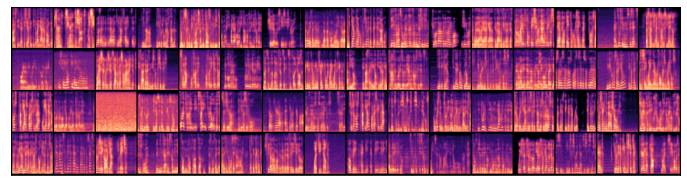

In [13]:
# view our batch
show_batch(train_dl)

That looks pretty awesome. It is definitely hard to tell these apart just by using our naked eye.

<a id="models"></a>
## Models
Here we will try a few different model architectures and see how they perform. We will begin with the simplest CNN model and increase the complexity as we go. First let's import our necessary modules and helper functions. Please note that the GPU related helper functions were borrowed from freecodecamp's [pytorch tutorial video on YouTube](https://youtu.be/GIsg-ZUy0MY).

In [14]:
import torch.nn as nn
import torch.nn.functional as F

In [2]:
# helper functions to use GPU (GOT THESE FROM FREECODECAMP'S PYTORCH TUTORIAL)
def get_device():
    '''Pick GPU, otherwise CPU if not avail'''
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    '''Move tensors to the chosen device'''
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

# using oop to set up a wrapper class for our dataloaders to use gpu
class DeviceDataLoader():
    '''Wraps a dataloader to move data into a device'''
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        '''Yields a batch of data after moving to device'''
        for i in self.dl:
            yield to_device(i, self.device)
    
    def __len__(self):
        '''Number of batches'''
        return len(self.dl)

In [2]:
# create confusion matrix
def generate_cm(model, dataloader, classes):
    label_list = []
    prediction_list = []

    with torch.no_grad():
        for batch in dataloader:
            inputs, labels = batch
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)

            if (torch.cuda.is_available()):
                torch.device('cuda')
                label_list.extend(list(labels.cpu().numpy()))
                prediction_list.extend(list(predicted.cpu().numpy()))
            else:
                label_list.extend(list(labels.numpy()))
                prediction_list.extend(list(predicted.numpy()))

    # calculate the confusion matrix
    cm = confusion_matrix(label_list, prediction_list, normalize="true")
    
    # plot the matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                  display_labels=classes)
    fig, ax = plt.subplots(figsize=(10, 10))
    disp = disp.plot(xticks_rotation='vertical', ax=ax, cmap='BuGn')
    plt.show()

# plot accuracies
def plot_accuracy(train_accuracy, val_accuracy):
    plt.figure(figsize=(7,5))
    plt.plot(train_accuracy, '-x')
    plt.plot(val_accuracy, '-o')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracies')
    plt.title('Accuracy vs Epochs')
    plt.show()
    
# plot losses
def plot_losses(train_losses, val_losses):
    plt.figure(figsize=(7,5))
    plt.plot(train_losses, '-x')
    plt.plot(val_losses, '-o')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.legend(['training', 'validation'])
    plt.title('Loss vs Epochs')
    plt.show()

In [4]:
## define functions to evaluate (get accuracy and loss) and fit the model

def evaluate(model, dataloader, calc_loss=False, opt=None, grad_clip=None):
    '''
    Helper function to get accuracy and loss(optional) even do a step with the optimizer if present
    We can use this function in multiple ways depending on the parameters: just calculate accuracy and/or loss and/or gradients + update weights
    This way, we can utilize this function for both validation and train dataloaders for each epoch
    
    Inputs
    model = the model 
    dataloader = validation or train or test dataloader
    calc_loss = set to True if you wish to calculate loss, else by default just returns empty list
    opt = set an optimizer function to calculate gradients and update weights, else None by default
    grad_clip = if not None, use gradient clipping, else default is None and it won't use gradient clipping. Controls for exploding / vanishing gradients.
    '''
    
    correct = 0
    total = 0
    losses = []
    
    if opt is not None:
        
        # calculate gradients and use optimizer
        for batch in dataloader:
            
            # forward pass through the model
            inputs, labels = batch
            outputs = model(inputs)
            
            # calculate loss if parameter set to True
            if (calc_loss==True):            
                loss = model.loss(outputs, labels)   # Calculate loss
                losses.append(loss.item())
            
            # compute gradients
            loss.backward()
            # update params
            opt.step()
            
            # Gradient clipping
            if grad_clip: 
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
                
            # reset gradients
            opt.zero_grad()
                               
            # Get the prediction of the net on the images
            _, predicted = torch.max(outputs.data, dim=1)
            total += labels.size(0)

            # Count those we got correct
            correct += torch.sum(predicted==labels).item()
                       
        # calculate total correct cases
        accuracy = 100 * correct / total
        avg_loss = np.mean(losses)
    
    else:
    
        # no gradients calculated
        with torch.no_grad():
            for batch in dataloader:

                # forward pass through the model
                inputs, labels = batch
                outputs = model(inputs)

                # calculate loss if parameter set to True
                if (calc_loss==True):            
                    loss = model.loss(outputs, labels)   # Calculate loss
                    losses.append(loss.item())

                # Get the prediction of the net on the images
                _, predicted = torch.max(outputs.data, dim=1)
                total += labels.size(0)

                # Count those we got correct
                correct += torch.sum(predicted==labels).item()

            # calculate total correct cases
            accuracy = 100 * correct / total
            avg_loss = np.mean(losses)
        
    return avg_loss, accuracy

# function to fit our model and train it
def fit(epochs, model, train_loader, val_loader, grad_clip=False):
    ''' Function where we fit the model and record the metrics for each epoch with the inputted hyperparameters'''
    
    # Instantiate our model and empty lists to record metrics
    model.cuda() # move model to GPU'
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []
    
    # train and validate for each epoch
    for epoch in range(epochs):

        ## Training Phase ##
        model.train()
        # run the evaluate function with optimizer to get train loss and accuracy
        train_loss, train_accuracy = evaluate(model, train_loader, calc_loss=True, opt=model.optimizer, grad_clip=grad_clip)
        
        # record training metrics
        train_losses.append(np.mean(train_loss))
        train_accuracies.append(np.mean(train_accuracy))
   
        ## Validation phase ##
        model.eval()
        # run the evaluate function on validation dataloader to get average loss and accuracy
        val_loss, val_accuracy = evaluate(model, val_loader, calc_loss=True) 
        
        # record validation metrics
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)
        
        # print the metrics
        print(f"Epoch: {epoch+1} / {epochs} | "\
            f"Avg Train Loss: {np.round(train_loss, 4)} | "\
            f"Train accuracy: {np.round(train_accuracy, 2)} | "\
            f"Avg Validation Loss: {np.round(val_loss, 4)} | "\
            f"Validation Accuracy: {np.round(val_accuracy, 2)}")

    return train_losses, train_accuracies, val_losses, val_accuracies

Now that we have defined all of our utility functions, let's make sure we are using the GPU. Then, we are ready to start creating and training our models.

In [17]:
# set up our dataloader and devices for GPU computing
device = get_device()
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)
device

device(type='cuda')

<a id="firstmodel"></a>
#### First Model
Let's try our first model: a simple CNN model with 6 convolutional layers and 1 dense layer. This model has a static layer sizes.

In [18]:
# First Simple Model
class CNN_model_1(nn.Module):
    def __init__(self, opt_fun, lr, **opt_params):
        '''
        opt_fun = optimizer function (eg: torch.optim.SGD)
        lr = learning rate
        **opt_params = extra optional parameters for optimizer function (eg: weight_decay, momentum, etc...)
        '''
        super(CNN_model_1, self).__init__()

        self.net = nn.Sequential(
            
            # convolution layers with max pooling 
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),  # our layer's input & output size, kernals, strides, padding 
            nn.ReLU(),                                             # activation function
            nn.MaxPool2d(2,2),                                     # max pooling: output 32x32x32

            nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1),        
            nn.ReLU(),          
            nn.MaxPool2d(2,2),                                     # output 32x16x16

            nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1),        
            nn.ReLU(),             
            nn.MaxPool2d(2,2),                                     # output 32x8x8

            nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1),        
            nn.ReLU(),            
            nn.MaxPool2d(2,2),                                     # output 32x4x4

            nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1),        
            nn.ReLU(),            
            nn.MaxPool2d(2,2),                                     # output 32x2x2

            nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1),        
            nn.ReLU(),           
            nn.MaxPool2d(2,2),                                     # output 32x1x1
            
            # flatten and pass through a dense layer
            nn.Flatten(),                                          # flattens to a vector 
            nn.Linear(32, 5)                                       # output of 4 for each one of our classes
        )
        
        self.loss = nn.CrossEntropyLoss()
        self.optimizer = opt_fun(self.parameters(), lr=lr, **opt_params)
    
    def forward(self, x):
        """Perform a forward pass and return the outputs"""
        return self.net(x)  # pass through the network

We are going to set our model to use a learning rate of 0.001. Since we have a relatively low batch size of 64, we will also use a relatively small learning rate to begin with. 

In [19]:
# initialize our model
model_1 = CNN_model_1(opt_fun=torch.optim.Adam, lr=0.001)
model_1.cuda()

CNN_model_1(
  (net): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (16): R

In [20]:
# quick check to see if evaluate and see if model is untrained and working
evaluate(model_1, dataloader=val_dl, calc_loss=True)

(1.613879603724326, 19.885714285714286)

The evaluate function returned us a loss of 1.6 and accuracy of ~20%. This seems correct, because we have 5 classes so 20% accuracy for an untrained model makes sense. Let's do the training and see what we get.

In [94]:
# training and validating our model
history = fit(epochs=20, model=model_1, train_loader=train_dl, val_loader=val_dl) 

Epoch: 1 / 20 | Avg Train Loss: 1.409 | Train accuracy: 36.91 | Avg Validation Loss: 1.2379 | Validation Accuracy: 47.7
Epoch: 2 / 20 | Avg Train Loss: 1.1667 | Train accuracy: 52.64 | Avg Validation Loss: 1.1712 | Validation Accuracy: 51.44
Epoch: 3 / 20 | Avg Train Loss: 1.0238 | Train accuracy: 59.78 | Avg Validation Loss: 0.9699 | Validation Accuracy: 61.46
Epoch: 4 / 20 | Avg Train Loss: 0.9247 | Train accuracy: 64.39 | Avg Validation Loss: 0.9131 | Validation Accuracy: 64.94
Epoch: 5 / 20 | Avg Train Loss: 0.8474 | Train accuracy: 67.51 | Avg Validation Loss: 0.8319 | Validation Accuracy: 68.39
Epoch: 6 / 20 | Avg Train Loss: 0.7866 | Train accuracy: 69.97 | Avg Validation Loss: 0.7653 | Validation Accuracy: 70.91
Epoch: 7 / 20 | Avg Train Loss: 0.7257 | Train accuracy: 72.57 | Avg Validation Loss: 0.7422 | Validation Accuracy: 71.75
Epoch: 8 / 20 | Avg Train Loss: 0.6786 | Train accuracy: 74.46 | Avg Validation Loss: 0.7012 | Validation Accuracy: 73.9
Epoch: 9 / 20 | Avg Train L

In [97]:
# load the metrics into separate variables from our fit
train_losses, train_accuracies, val_losses, val_accuracies = history

Let's visualize our metrics and see how our model performed after 20 epochs.

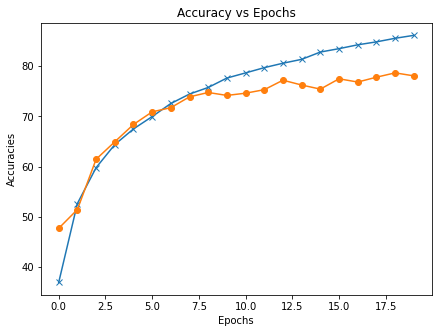

In [98]:
# plot metrics
plot_accuracy(train_accuracies, val_accuracies)

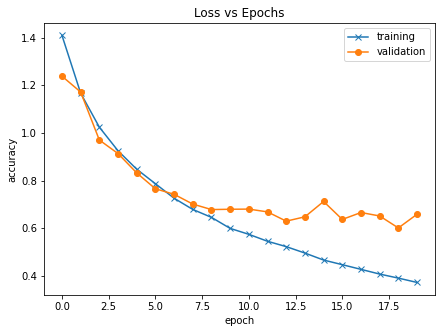

In [101]:
plot_losses(train_losses, val_losses)

It seems like our model is leveling out after about 8-9 epochs. The validation accuracy is around 77-78%. Let's see how this model performs on the test set. 

In [111]:
# set up our test dataloader
test_dl = DeviceDataLoader(DataLoader(testset, batch_size*2), device)

test_loss_1, test_score_1 = evaluate(model_1, dataloader=test_dl, calc_loss=True)

print(f"Test Score: {test_score_1:.2f}% | Test Loss: {test_loss_1:.4f}")

Test Score: 72.53% | Test Loss: 0.9239


The test score is lower than our validation score as expected. It is performing pretty well for a 5 class classification model. Let's save this model and try a more complex one.

In [112]:
# save the state model of the trained model
torch.save(model_1.state_dict(), "trained_model_1_state.pt")

## to load:
#new_model_1 = CNN_model_1()
#new_model_1.load_state_dict(torch.load("trained_model_1_state.pt"))
#new_model_1

<a id="secondmodel"></a>
#### Second Model - Expanding Layers
For our second model, we will be adding more layers and have expanding convolution layer sizes instead of the static ones like before. We will then flatten and shrink them down in the dense layers. In contrast to our first model which had static layers, we are going to blow the layers up and then condense them to see if we can snythesize more information this way. 

In [18]:
# Second Model
class CNN_model_2(nn.Module):
    def __init__(self, opt_fun, lr, **opt_params):
        '''
        opt_fun = optimizer function (eg: torch.optim.SGD)
        lr = learning rate
        **opt_params = extra optional parameters for optimizer function (eg: weight_decay, momentum, etc...)
        '''
        super(CNN_model_2, self).__init__()

        self.net = nn.Sequential(
            
            # convolution layers
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 128 x 32 x 32
            
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 256 x 16 x 16

            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 512 x 8 x 8
            
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 1024 x 4 x 4
            
            # dense layers
            nn.Flatten(), 
            nn.Linear(512*4*4, 1024),  # is 1024*4*4 because of the dimension of the last maxpool
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 5))
        
        self.loss = nn.CrossEntropyLoss()
        self.optimizer = opt_fun(self.parameters(), lr=lr, **opt_params)
    
    def forward(self, x):
        """Perform a forward pass and return the outputs"""
        return self.net(x)  # pass through the network

Let's keep the same hyperparameters as the previous model so we can have a constant baseline and only measure the core model performance.

In [19]:
# initialize our model
model_2 = CNN_model_2(opt_fun=torch.optim.Adam, lr=0.001)
model_2.cuda()

CNN_model_2(
  (net): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (16): ReLU()
    (17): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1)

In [21]:
# quick check to see if evaluate and see if model is untrained and working
evaluate(model_2, dataloader=val_dl, calc_loss=True)

(1.6094968857303742, 19.86031746031746)

Again, we have ~20% accuracy, this makes sense for an untrained model. Let's do the training now.

In [21]:
# empty the cache in our GPU before we train another model
torch.cuda.empty_cache()

In [23]:
# training and validating our model
history2 = fit(epochs=20, model=model_2, train_loader=train_dl, val_loader=val_dl)

Epoch: 1 / 20 | Avg Train Loss: 1.4657 | Train accuracy: 32.41 | Avg Validation Loss: 1.3013 | Validation Accuracy: 44.9
Epoch: 2 / 20 | Avg Train Loss: 1.1934 | Train accuracy: 50.33 | Avg Validation Loss: 1.0923 | Validation Accuracy: 56.86
Epoch: 3 / 20 | Avg Train Loss: 0.98 | Train accuracy: 61.69 | Avg Validation Loss: 0.8693 | Validation Accuracy: 66.86
Epoch: 4 / 20 | Avg Train Loss: 0.8207 | Train accuracy: 68.63 | Avg Validation Loss: 0.7597 | Validation Accuracy: 71.38
Epoch: 5 / 20 | Avg Train Loss: 0.6871 | Train accuracy: 73.9 | Avg Validation Loss: 0.6714 | Validation Accuracy: 74.87
Epoch: 6 / 20 | Avg Train Loss: 0.5761 | Train accuracy: 78.47 | Avg Validation Loss: 0.6264 | Validation Accuracy: 76.06
Epoch: 7 / 20 | Avg Train Loss: 0.5023 | Train accuracy: 81.15 | Avg Validation Loss: 0.6136 | Validation Accuracy: 77.36
Epoch: 8 / 20 | Avg Train Loss: 0.4223 | Train accuracy: 84.36 | Avg Validation Loss: 0.5742 | Validation Accuracy: 79.15
Epoch: 9 / 20 | Avg Train Lo

In [24]:
# load the metrics into separate variables from our fit
train_losses, train_accuracies, val_losses, val_accuracies = history2

We seem to get marginally better performance, but not enough to make a big difference. Let's visualize the loss and accuracy scores and see how we did.

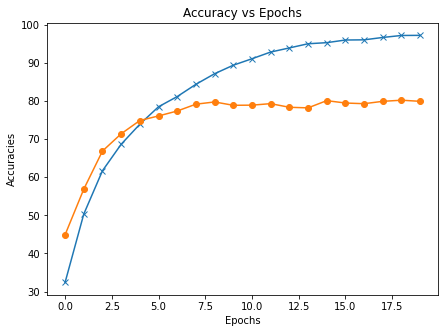

In [25]:
# plot metrics
plot_accuracy(train_accuracies, val_accuracies)

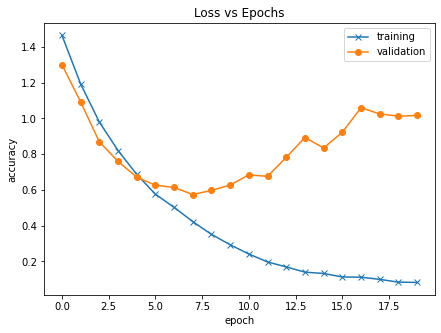

In [26]:
plot_losses(train_losses, val_losses)

It seems like we are leveling out after 8 epochs, as our validation loss hit a minimum there and started increasing. This shows that we are overfitting after 8 epochs. To account for this we can do early stopping there. However, it seems like the validation accuracy leveled out around ~79-80% accuracy. Let's see how our test accuracy is:

In [30]:
# set up our test dataloader
test_dl = DeviceDataLoader(DataLoader(testset, batch_size*2), device)

# calculate test score
test_loss_2, test_score_2 = evaluate(model_2, dataloader=test_dl, calc_loss=True)

print(f"Test Score: {test_score_2:.2f}% | Test Loss: {test_loss_2:.4f}")

Test Score: 71.12% | Test Loss: 1.8343


We performed worse on our test score despite slightly higher validation accuracy. This makes sense, as we saw the model overfitting after about 8 epochs. We may get better results on the test set if we train the model again and early stop around 8 epochs. However, let's save this model and try our third model before any tuning. 

In [28]:
# save the state model of the trained model
torch.save(model_2.state_dict(), "trained_model_2_state.pt")

## to load:
#new_model_2 = CNN_model_2()
#new_model_2.load_state_dict(torch.load("trained_model_2_state.pt"))
#new_model_2

<a id="thirdmodel"></a>
#### Third Model - Adding Batch Norm & Drop Out
In this model we have added Batch Normalization and Dropout. We have added Batch Normalization before every activation function and Drop Out after each maxpooling. From a bit of research and reading, it seems like this sequence is prefered by most people. Let's see how it performs. I chose to add these due as they are the basic regularization techniques you would apply to a neural network. As you may have noticed, we are doing a sort of ground up approach to model building where we start with the most cookie cutter methods and expand further as we go. 

In [20]:
# Third Model
class CNN_model_3(nn.Module):
    def __init__(self, opt_fun, lr, **opt_params):
        '''
        opt_fun = optimizer function (eg: torch.optim.SGD)
        lr = learning rate
        **opt_params = extra optional parameters for optimizer function (eg: weight_decay, momentum, etc...)
        '''
        super(CNN_model_3, self).__init__()

        self.net = nn.Sequential(
            
           # convolution layers
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),     # adding batch normalization
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 128 x 32 x 32
            nn.Dropout(p=0.25), # adding dropout regularization
            
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 256 x 16 x 16
            nn.Dropout(p=0.25),

            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 512 x 8 x 8
            nn.Dropout(p=0.25),
            
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 512 x 4 x 4
            nn.Dropout(p=0.25),
            
            # flatten then go through some dense layers
            nn.Flatten(), 
            nn.Linear(512*4*4, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Dropout(p=0.25),
            nn.Linear(1024, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(p=0.25),
            nn.Linear(512, 5))   # output of 5 for each of our class
        
        self.loss = nn.CrossEntropyLoss()
        self.optimizer = opt_fun(self.parameters(), lr=lr, **opt_params)
    
    def forward(self, x):
        """Perform a forward pass and return the outputs"""
        return self.net(x)  # pass through the network

In [19]:
# initialize our model
model_3 = CNN_model_3(opt_fun=torch.optim.Adam, lr=0.001)
model_3.cuda()

CNN_model_3(
  (net): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Dropout(p=0.25, inplace=False)
    (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Dropout(p=0.25, 

In [20]:
# quick check to see if evaluate and see if model is untrained and working
evaluate(model_3, dataloader=val_dl, calc_loss=True)

(1.6864221672857962, 20.152380952380952)

Again, looks good, we have an untrained model that is ready to be trained.

In [22]:
# empty the cache in our GPU before we train another model
torch.cuda.empty_cache()

In [43]:
# training and validating our model
history3 = fit(epochs=20, model=model_3, train_loader=train_dl, val_loader=val_dl)

Epoch: 1 / 20 | Avg Train Loss: 1.029 | Train accuracy: 59.16 | Avg Validation Loss: 1.1797 | Validation Accuracy: 56.24
Epoch: 2 / 20 | Avg Train Loss: 0.6353 | Train accuracy: 76.2 | Avg Validation Loss: 0.5562 | Validation Accuracy: 79.31
Epoch: 3 / 20 | Avg Train Loss: 0.466 | Train accuracy: 83.07 | Avg Validation Loss: 0.5335 | Validation Accuracy: 80.84
Epoch: 4 / 20 | Avg Train Loss: 0.3602 | Train accuracy: 86.8 | Avg Validation Loss: 0.4378 | Validation Accuracy: 83.78
Epoch: 5 / 20 | Avg Train Loss: 0.288 | Train accuracy: 89.75 | Avg Validation Loss: 0.4178 | Validation Accuracy: 85.55
Epoch: 6 / 20 | Avg Train Loss: 0.2346 | Train accuracy: 91.53 | Avg Validation Loss: 0.3089 | Validation Accuracy: 88.93
Epoch: 7 / 20 | Avg Train Loss: 0.1952 | Train accuracy: 93.13 | Avg Validation Loss: 0.2454 | Validation Accuracy: 91.52
Epoch: 8 / 20 | Avg Train Loss: 0.1656 | Train accuracy: 94.19 | Avg Validation Loss: 0.2908 | Validation Accuracy: 89.98
Epoch: 9 / 20 | Avg Train Los

In [44]:
# load the metrics into separate variables from our fit
train_losses, train_accuracies, val_losses, val_accuracies = history3

So it seems like adding batch normalization and drop out really improved our model's performance as we increased the validation accuracy by over 10%! Let's visualize the performance over epochs.

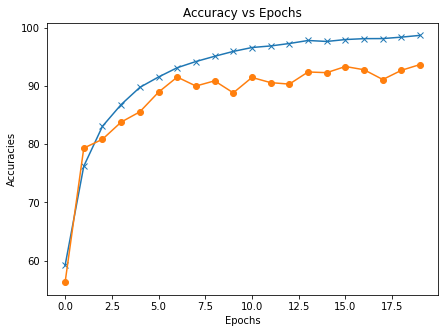

In [45]:
# plot metrics
plot_accuracy(train_accuracies, val_accuracies)

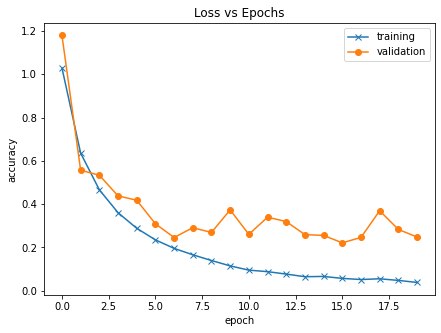

In [46]:
plot_losses(train_losses, val_losses)

We seem to be leveling out after a certain number of epochs as the validation accuracy hovers around 91-93%. We do not really see a rise in validation loss yet, which means our model hasn't really overfit too much./ Nevertheless, let's see our test score and how this model performs.

In [48]:
# set up our test dataloader
test_dl = DeviceDataLoader(DataLoader(testset, batch_size*2), device)

# calculate test score
test_loss_3, test_score_3 = evaluate(model_3, dataloader=test_dl, calc_loss=True)

print(f"Test Score: {test_score_3:.2f}% | Test Loss: {test_loss_3:.4f}")

Test Score: 85.66% | Test Loss: 0.6416


Our test accuracy is much lower than our validation score, but it improved by over 10% compared to the previous two models! I think this model architecture is without doubt the best one. Let's now see how this model did in terms of classifying each class, and we can start to try some hyperparameter tuning.

#### Confusion Matrix - Third Model
Given that the third model was the best performing model, ;et's take a look at the confusion matrix of how it performed with the test data.

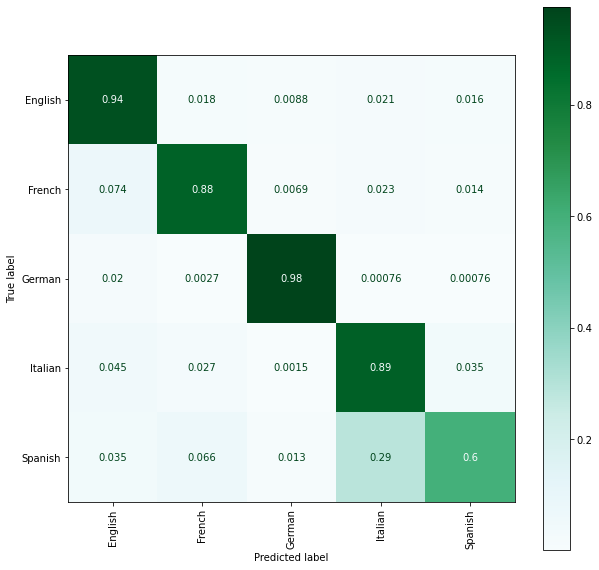

In [121]:
# create confusion matrix
generate_cm(model_3, test_dl, classes)

Seems like spanish is the only language that has some issues, especially with getting a lot of them being classified as Italian. This could be how well these two languages are related as latin languages. Nevertheless, this seems to be the best model out of the three. So let's take this model and try to see if we can improve it even more through some hyperparameter tuning. We may also want to add more regularization to see if it will help since we had success previously with batch normalization and dropout.

In [49]:
# save the state model of the trained model
torch.save(model_3.state_dict(), "trained_model_3_state.pt")

## to load:
#new_model_3 = CNN_model_3()
#new_model_3.load_state_dict(torch.load("trained_model_3_state.pt"))
#new_model_3

<a id="optparam"></a>
## Optimizing Hyperparameters
Seems like model 3 with batch normalization and dropout is the best performing model. Let's now try and tune the hyperparameters. We will adjust the follow parameters:

**Weight decay**: The more complex our model is, the higher chance it will overfit. Weight Decay is a regularization technique which prevents the weights from becoming too large by adding an additional term to the loss function. This way, we can penalize complexity and help reduce overfitting. From the train/validation/test results we see that as we run more epochs, the bigger the training accuracy grows, but the validation accuracy stays relatively the same. This is suggesting that there is increasing overfitting. We can also do early stopping (stop the model at an epoch before overfitting happens), but let's see how we perform with weight decay regularization first. Since our model isn't too complex, we can start with lower values: 0.01 and 0.0001. The default value is 0 in torch.optim.Adam.

**Gradient clipping**: This limits the gradients to a specified (usually small) range. This will help to prevent undesirable changes in parameters due to large gradient values. This can help combat both exploding gradients and vanishing gradients, and potentially improve the model's ability to find the true local minimum. We can start with 0.1.

**Learning Rate**: We will try for different values of learning rates. However, from studies I have read, it seems like smaller batches do better with smaller learning rates. Therefore, since our batch size is only 64, we should actually go for a small learning rate. I propose trying both 0.001 and 0.0001.

**Epochs**: We have seen in the previous example that 20 epochs seem to be leveling out. However, there isn't a noticable increase or global min in the loss vs epochs graph. This suggests that we can try a large epoch and then retrain at a more desirable value. We can also set a parameter to stop the model if the loss or accuracy isn't changing by much anymore. We will also be manually stopping the models early if there are signs that the model just isn't training properly.

As for the loss function, optimizer, kernel size, stride, padding ... we will leave those as is, since it does seem to working well with the model we have. There is no need to change the achitecture or the optimizer at this point. 

<a id="firstver"></a>
#### First Version
First we will try to add weight decay and gradient clipping. We will set our weight decay at 0.01 and gradient clipping at 0.1. We want to start off not too high since our model is not overly complex and already has some regularization already.

In [181]:
# trying our first tuned model with wd=0.01 
model_3_opt1 = CNN_model_3(opt_fun=torch.optim.Adam, lr=0.001, weight_decay=0.01)
model_3_opt1.cuda()

CNN_model_3(
  (net): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Dropout(p=0.25, inplace=False)
    (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Dropout(p=0.25, 

In [183]:
# training and validating our model with GRADIENT CLIPPING
history_opt1 = fit(epochs=30, model=model_3_opt1, train_loader=train_dl, val_loader=val_dl, grad_clip=0.1)

Epoch: 1 / 30 | Avg Train Loss: 1.1287 | Train accuracy: 55.19 | Avg Validation Loss: 1.2817 | Validation Accuracy: 49.66
Epoch: 2 / 30 | Avg Train Loss: 0.9908 | Train accuracy: 62.11 | Avg Validation Loss: 1.0294 | Validation Accuracy: 59.06
Epoch: 3 / 30 | Avg Train Loss: 0.9788 | Train accuracy: 62.71 | Avg Validation Loss: 2.8254 | Validation Accuracy: 20.36
Epoch: 4 / 30 | Avg Train Loss: 0.9407 | Train accuracy: 64.43 | Avg Validation Loss: 1.4848 | Validation Accuracy: 39.92


KeyboardInterrupt: 

**I manually stopped our model, because it seems like our model is just not fitting. This is because our weight decay value is too high. When the value is too high, the model can no longer fit well enough no matter how long we train for. Seems like we need a much lower weight decay. Let's try 0.0001.**

<a id="secondver"></a>
#### Second Version
Since a weight decay of 0.001 still seems too high, let's lower the weight decay and try again. This time we will use 0.0001.

In [22]:
# trying our SECOND tuned model with wd=0.01
model_3_opt2 = CNN_model_3(opt_fun=torch.optim.Adam, lr=0.001, weight_decay=0.0001)
model_3_opt2.cuda()

CNN_model_3(
  (net): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Dropout(p=0.25, inplace=False)
    (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Dropout(p=0.25, 

In [24]:
# training and validating our model with GRADIENT CLIPPING
history_opt2 = fit(epochs=30, model=model_3_opt2, train_loader=train_dl, val_loader=val_dl, grad_clip=0.1)

Epoch: 1 / 30 | Avg Train Loss: 1.0182 | Train accuracy: 60.03 | Avg Validation Loss: 1.1025 | Validation Accuracy: 57.82
Epoch: 2 / 30 | Avg Train Loss: 0.6383 | Train accuracy: 76.3 | Avg Validation Loss: 0.88 | Validation Accuracy: 69.46
Epoch: 3 / 30 | Avg Train Loss: 0.4805 | Train accuracy: 82.63 | Avg Validation Loss: 0.502 | Validation Accuracy: 81.16
Epoch: 4 / 30 | Avg Train Loss: 0.3885 | Train accuracy: 85.95 | Avg Validation Loss: 0.4308 | Validation Accuracy: 84.43
Epoch: 5 / 30 | Avg Train Loss: 0.3288 | Train accuracy: 88.18 | Avg Validation Loss: 0.4601 | Validation Accuracy: 84.14
Epoch: 6 / 30 | Avg Train Loss: 0.2898 | Train accuracy: 89.47 | Avg Validation Loss: 0.3223 | Validation Accuracy: 88.43
Epoch: 7 / 30 | Avg Train Loss: 0.2628 | Train accuracy: 90.61 | Avg Validation Loss: 0.3803 | Validation Accuracy: 86.12
Epoch: 8 / 30 | Avg Train Loss: 0.2431 | Train accuracy: 91.25 | Avg Validation Loss: 0.2837 | Validation Accuracy: 90.12
Epoch: 9 / 30 | Avg Train Lo

In [25]:
# load the metrics into separate variables from our fit
train_losses, train_accuracies, val_losses, val_accuracies = history_opt2

This time the model gained traction, but our validation accuracy did not improve compared to the original baseline model.

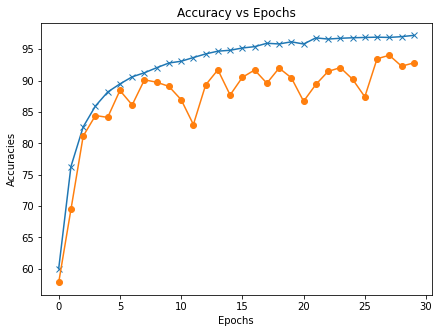

In [26]:
# plot metrics
plot_accuracy(train_accuracies, val_accuracies)

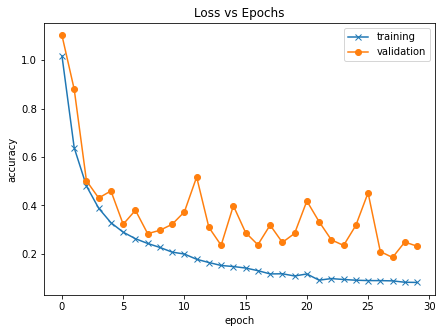

In [27]:
plot_losses(train_losses, val_losses)

There is a lot of bouncing with our loss. That is interesting because we added gradient clipping to avoid any sort of big random jumps. However we do see loss gradually getting lower despite shooting up every so often. Let's see if our test score was able to improve now that we added some regularization to avoid overfitting.

In [28]:
# set up our test dataloader
test_dl = DeviceDataLoader(DataLoader(testset, batch_size*2), device)

# calculate test score
test_loss, test_score = evaluate(model_3_opt2, dataloader=test_dl, calc_loss=True)

print(f"Test Score: {test_score:.2f}% | Test Loss: {test_loss:.4f}")

Test Score: 83.54% | Test Loss: 0.6451


It seems like this model and the baseline model performed relatively similar, with marginal differences of a 1-2%. This is not significant enough to warrant any conclusions. 

#### Confusion Matrix
Let's take a look at the confusion matrix of how this model performed with the test data.

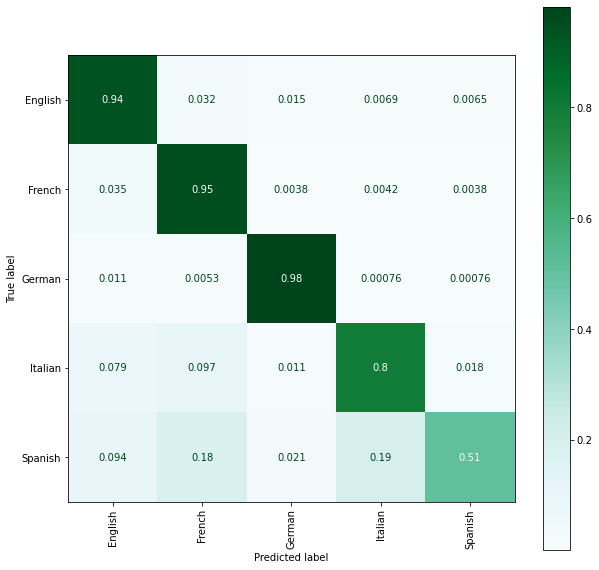

In [122]:
generate_cm(model_3_opt2, test_dl, classes)

It is still confusing Spanish with a lot of other languages. This model is performing slightly worse than our first one. There also doesn't seem to be any real changes to our accuracy scores. However, we do see that the training accuracy and validation accuracy are a lot closer, so there is less overfitting. Yet, in the confusion matrix, we do see more confusion between Italian and Spanish.

In [29]:
# save the state model of the trained model
torch.save(model_3_opt2.state_dict(), "trained_model_3_opt2_state.pt")

## to load:
#new_model_3 = CNN_model_3()
#new_model_3.load_state_dict(torch.load("trained_model_3_opt2_state.pt"))
#new_model_3

<a id="thirdver"></a>
#### Third Version
So now that we have found a decent weight decay and gradient clipping value, I think we should try to adjust the learning rate to 0.0001 and see what we get. After this, we can use the most optimal model and epoch and retrain our final model on the validation and training set combined.

In [21]:
# trying our SECOND tuned model with wd=0.01
model_3_opt3 = CNN_model_3(opt_fun=torch.optim.Adam, lr=0.0001, weight_decay=0.0001)
model_3_opt3.cuda()

CNN_model_3(
  (net): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Dropout(p=0.25, inplace=False)
    (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Dropout(p=0.25, 

In [23]:
# training and validating our model with GRADIENT CLIPPING
history_opt3 = fit(epochs=30, model=model_3_opt3, train_loader=train_dl, val_loader=val_dl, grad_clip=0.1)

Epoch: 1 / 30 | Avg Train Loss: 1.0837 | Train accuracy: 56.64 | Avg Validation Loss: 1.0123 | Validation Accuracy: 61.36
Epoch: 2 / 30 | Avg Train Loss: 0.703 | Train accuracy: 73.78 | Avg Validation Loss: 0.7855 | Validation Accuracy: 72.13
Epoch: 3 / 30 | Avg Train Loss: 0.5124 | Train accuracy: 81.43 | Avg Validation Loss: 0.5506 | Validation Accuracy: 79.91
Epoch: 4 / 30 | Avg Train Loss: 0.3959 | Train accuracy: 85.83 | Avg Validation Loss: 0.4352 | Validation Accuracy: 84.13
Epoch: 5 / 30 | Avg Train Loss: 0.304 | Train accuracy: 89.2 | Avg Validation Loss: 0.4539 | Validation Accuracy: 83.9
Epoch: 6 / 30 | Avg Train Loss: 0.2444 | Train accuracy: 91.25 | Avg Validation Loss: 0.3226 | Validation Accuracy: 88.32
Epoch: 7 / 30 | Avg Train Loss: 0.1979 | Train accuracy: 92.98 | Avg Validation Loss: 0.3765 | Validation Accuracy: 87.09
Epoch: 8 / 30 | Avg Train Loss: 0.1652 | Train accuracy: 94.13 | Avg Validation Loss: 0.2341 | Validation Accuracy: 92.01
Epoch: 9 / 30 | Avg Train Lo

In [24]:
# load the metrics into separate variables from our fit
train_losses, train_accuracies, val_losses, val_accuracies = history_opt3

From a glance, we managed to improve the validation accuracy by 1% or so compared to our baseline model. However, due to the randomized intial weights of neural networks, this is not big enough of a difference to warrant any claims of improvement.

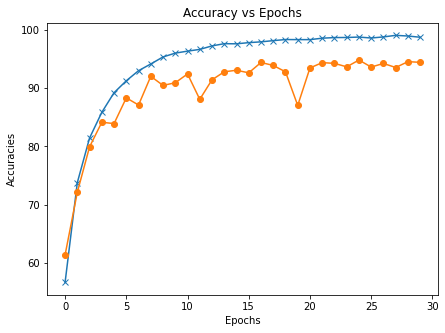

In [25]:
# plot metrics
plot_accuracy(train_accuracies, val_accuracies)

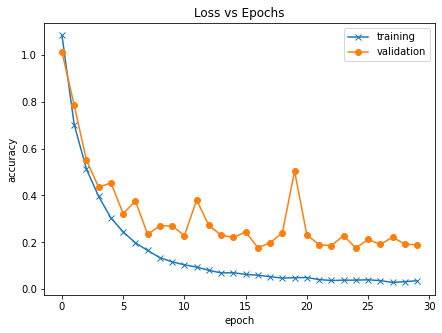

In [26]:
plot_losses(train_losses, val_losses)

The loss seems to be traveling steadier (except at around epoch 20). We don't really see heavy overfitting like we did in model 2, but we did level out at around the same performance as the previous two models. Let's see how our model performs with the test data. 

In [27]:
# set up our test dataloader
test_dl = DeviceDataLoader(DataLoader(testset, batch_size*2), device)

# calculate test score
test_loss, test_score = evaluate(model_3_opt3, dataloader=test_dl, calc_loss=True)

print(f"Test Score: {test_score:.2f}% | Test Loss: {test_loss:.4f}")

Test Score: 81.90% | Test Loss: 0.8470


We see a drop in test score, almost 4% difference compared to our original model. This is interesting as we have added a lot more regularization but we don't really see much improvement.

#### Confusion Matrix
Let's take a look at the confusion matrix of how this model performed with the test data.

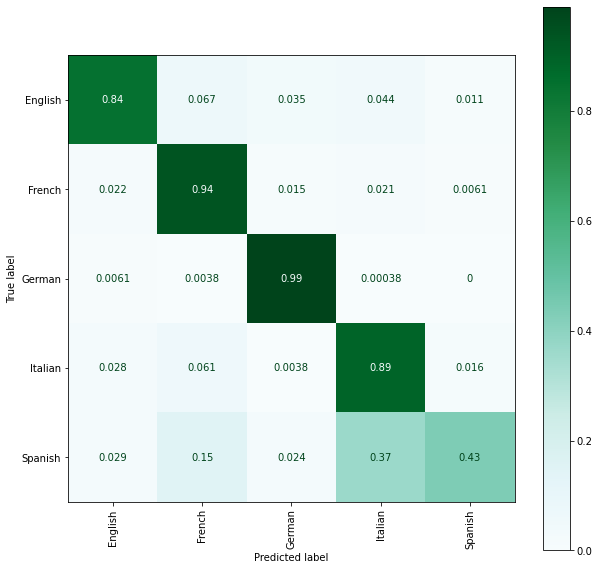

In [123]:
generate_cm(model_3_opt3, test_dl, classes)

This model is the worst performing one. Such a low learning rate could be the reason. However, we have not tried to perform any form of early stopping yet. Let's try that and see how we fair.

In [28]:
# save the state model of the trained model
torch.save(model_3_opt3.state_dict(), "trained_model_3_opt3_state.pt")

## to load:
#new_model_3 = CNN_model_3()
#new_model_3.load_state_dict(torch.load("trained_model_3_opt3_state.pt"))
#new_model_3

<a id="results"></a>
#### Recap Our Results
- Baseline Model 3: ~98% train | ~93% validation | ~85% test
- 1st optimizing attempt: Failed to fit properly, weight decay was too high
- 2nd optimizing attempt: ~97% train | ~92% validation | ~83% test
- 3rd optimizing attempt: ~98% train | ~94% validation | ~81% test

Our test scores seem to be getting lower for each of these models. However our validation set's accuracy are around the same at 92-93%. 


<a id="earlystop"></a>
## Early Stopping
Next, we can perform early stopping for each of these models based on the loss vs epochs graph. We can then train the entire training set on the optimal epoch for each of these models and try scoring it again with the test set. We will then select the model with the best test accuracy. 

**Early stopping at these epochs:**

I looked at the loss and accuracy and chose the epochs at the value where loss is lowest or was first lowest.

- Baseline Model - 7th epoch
- Second Optimized Model - 8th epoch
- Third optimized model - 17th epoch

So for these epochs, it looked like the loss is starting to level out and we are not getting any more gains. 

<a id="baseline"></a>
#### Baseline Model - Early Stopping
Retraining our baseline model but this time we stop at after the 7th epoch. 

In [19]:
# initialize our model
model_3_final = CNN_model_3(opt_fun=torch.optim.Adam, lr=0.001)
model_3_final.cuda()

CNN_model_3(
  (net): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Dropout(p=0.25, inplace=False)
    (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Dropout(p=0.25, 

In [20]:
history_baseline = fit(epochs=7, model=model_3_final, train_loader=train_dl, val_loader=val_dl)

Epoch: 1 / 7 | Avg Train Loss: 1.0313 | Train accuracy: 59.26 | Avg Validation Loss: 0.9446 | Validation Accuracy: 63.64
Epoch: 2 / 7 | Avg Train Loss: 0.6373 | Train accuracy: 76.38 | Avg Validation Loss: 0.9111 | Validation Accuracy: 68.88
Epoch: 3 / 7 | Avg Train Loss: 0.4655 | Train accuracy: 83.06 | Avg Validation Loss: 0.8281 | Validation Accuracy: 72.85
Epoch: 4 / 7 | Avg Train Loss: 0.3605 | Train accuracy: 87.05 | Avg Validation Loss: 0.4884 | Validation Accuracy: 82.63
Epoch: 5 / 7 | Avg Train Loss: 0.28 | Train accuracy: 89.88 | Avg Validation Loss: 0.3089 | Validation Accuracy: 89.18
Epoch: 6 / 7 | Avg Train Loss: 0.231 | Train accuracy: 91.97 | Avg Validation Loss: 0.3164 | Validation Accuracy: 89.27
Epoch: 7 / 7 | Avg Train Loss: 0.1855 | Train accuracy: 93.47 | Avg Validation Loss: 0.2833 | Validation Accuracy: 90.32


In [24]:
train_losses, train_accuracies, val_losses, val_accuracies = history_baseline

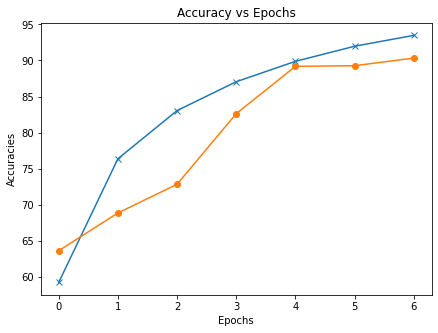

In [25]:
# plot metrics
plot_accuracy(train_accuracies, val_accuracies)

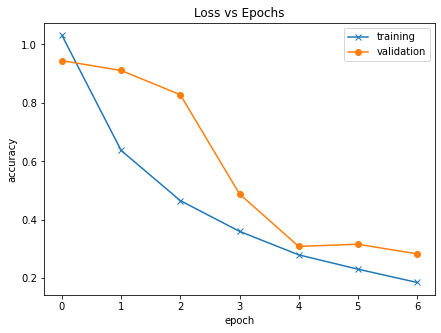

In [26]:
plot_losses(train_losses, val_losses)

We seemed to have gotten worse performance. However, our training time was shortened immensely. 

In [21]:
# set up our test dataloader
test_dl = DeviceDataLoader(DataLoader(testset, batch_size*2), device)

# calculate test score
test_loss, test_score = evaluate(model_3_final, dataloader=test_dl, calc_loss=True)

print(f"Test Score: {test_score:.2f}% | Test Loss: {test_loss:.4f}")

Test Score: 78.84% | Test Loss: 0.7145


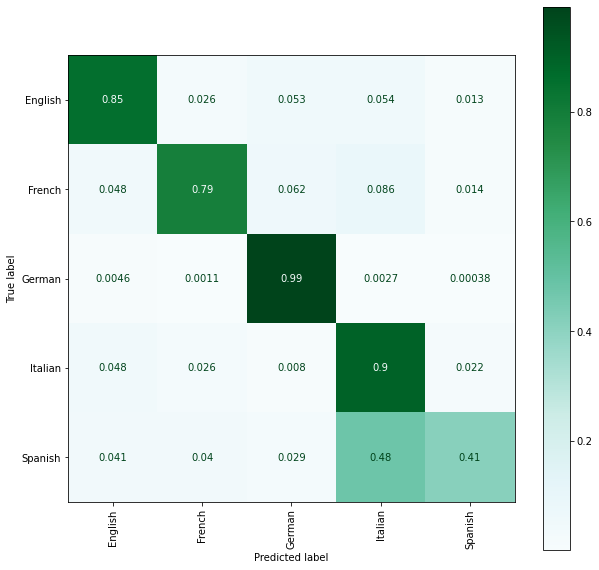

In [134]:
# Evaluate with the confusion matrix
generate_cm(model_3_final, test_dl)

This seems to be worse in performance than our original baseline model. The English and French accuracy has dropped, and the Spanish is even more torn between Italian and Spanish.

<a id="optmod2"></a>
#### Optimized Model 2 - Early Stopping
Trying early stopping with our [second optimized model](#secondver). Recall weight decay was set to 0.0001 here.

In [21]:
# trying our SECOND tuned model with wd=0.0001
model_opt2_final = CNN_model_3(opt_fun=torch.optim.Adam, lr=0.001, weight_decay=0.0001)
model_opt2_final.cuda()

CNN_model_3(
  (net): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Dropout(p=0.25, inplace=False)
    (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Dropout(p=0.25, 

In [22]:
history_opt2_final = fit(epochs=8, model=model_opt2_final, train_loader=train_dl, val_loader=val_dl, grad_clip=0.1)

Epoch: 1 / 8 | Avg Train Loss: 1.0003 | Train accuracy: 60.74 | Avg Validation Loss: 0.9324 | Validation Accuracy: 66.34
Epoch: 2 / 8 | Avg Train Loss: 0.6157 | Train accuracy: 77.19 | Avg Validation Loss: 0.7469 | Validation Accuracy: 72.0
Epoch: 3 / 8 | Avg Train Loss: 0.4634 | Train accuracy: 83.15 | Avg Validation Loss: 0.402 | Validation Accuracy: 85.73
Epoch: 4 / 8 | Avg Train Loss: 0.3766 | Train accuracy: 86.44 | Avg Validation Loss: 0.5234 | Validation Accuracy: 83.05
Epoch: 5 / 8 | Avg Train Loss: 0.3251 | Train accuracy: 88.25 | Avg Validation Loss: 0.4452 | Validation Accuracy: 83.53
Epoch: 6 / 8 | Avg Train Loss: 0.286 | Train accuracy: 89.7 | Avg Validation Loss: 0.4606 | Validation Accuracy: 83.63
Epoch: 7 / 8 | Avg Train Loss: 0.26 | Train accuracy: 90.65 | Avg Validation Loss: 0.3801 | Validation Accuracy: 86.83
Epoch: 8 / 8 | Avg Train Loss: 0.2455 | Train accuracy: 91.04 | Avg Validation Loss: 0.3675 | Validation Accuracy: 86.87


In [23]:
train_losses, train_accuracies, val_losses, val_accuracies = history_opt2_final

The validation accuracy looks to be much lower, a significant drop from the original 92%. 

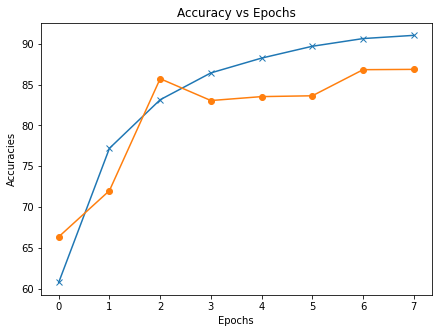

In [24]:
# plot metrics
plot_accuracy(train_accuracies, val_accuracies)

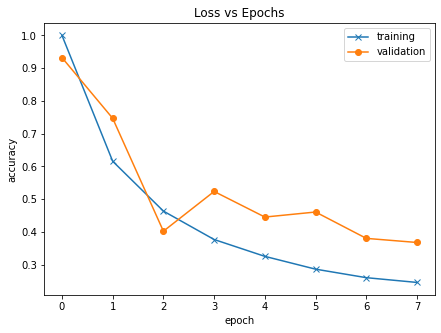

In [25]:
plot_losses(train_losses, val_losses)

In [26]:
# set up our test dataloader
test_dl = DeviceDataLoader(DataLoader(testset, batch_size*2), device)

# calculate test score
test_loss, test_score = evaluate(model_opt2_final, dataloader=test_dl, calc_loss=True)

print(f"Test Score: {test_score:.2f}% | Test Loss: {test_loss:.4f}")

Test Score: 78.31% | Test Loss: 0.6464


This by far has been the worst performing model in terms of accuracy. The average test loss however seems to be okay. 

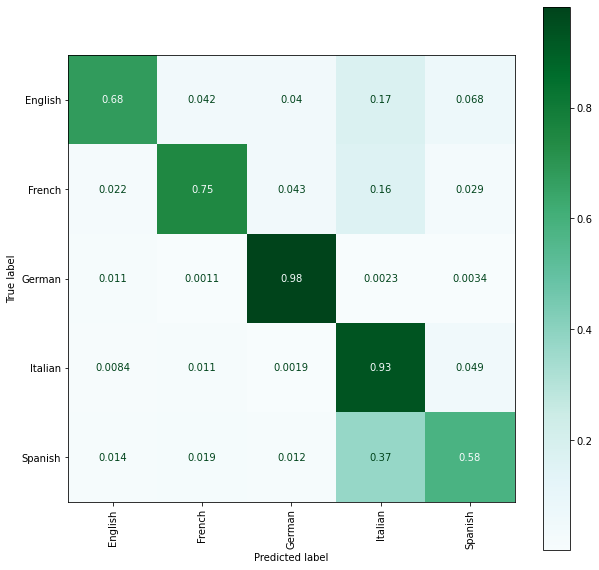

In [33]:
# Look at our confusion matrix
generate_cm(model_opt2_final, test_dl)

We definitely see a lot of languages being confused for Italian. In this model, English and French are also being confused for Italian, but Spanish is a bit less so. This is interesting, as all these languages are latin rooted languages. German seems to be the easiest to detect.

<a id="optmod3"></a>
#### Optimized Model 3 - Early Stopping
Doing early stopping on our [third optimized model](#thirdver). Recall that this model has a learning rate of 0.0001 and a weight decay of 0.0001. 

In [5]:
# trying our THIRD tuned model with wd=0.0001 and wd=0.0001
model_opt3_final = CNN_model_3(opt_fun=torch.optim.Adam, lr=0.0001, weight_decay=0.0001)
model_opt3_final.cuda()

In [42]:
history_opt3_final = fit(epochs=17, model=model_opt3_final, train_loader=train_dl, val_loader=val_dl, grad_clip=0.1)

Epoch: 1 / 17 | Avg Train Loss: 1.0765 | Train accuracy: 57.05 | Avg Validation Loss: 0.8958 | Validation Accuracy: 64.51
Epoch: 2 / 17 | Avg Train Loss: 0.6987 | Train accuracy: 73.72 | Avg Validation Loss: 0.7122 | Validation Accuracy: 72.53
Epoch: 3 / 17 | Avg Train Loss: 0.5156 | Train accuracy: 81.06 | Avg Validation Loss: 0.9345 | Validation Accuracy: 67.76
Epoch: 4 / 17 | Avg Train Loss: 0.399 | Train accuracy: 85.81 | Avg Validation Loss: 0.3829 | Validation Accuracy: 86.39
Epoch: 5 / 17 | Avg Train Loss: 0.3053 | Train accuracy: 89.2 | Avg Validation Loss: 0.3388 | Validation Accuracy: 88.03
Epoch: 6 / 17 | Avg Train Loss: 0.2549 | Train accuracy: 90.95 | Avg Validation Loss: 0.2832 | Validation Accuracy: 89.75
Epoch: 7 / 17 | Avg Train Loss: 0.2087 | Train accuracy: 92.58 | Avg Validation Loss: 0.2822 | Validation Accuracy: 90.22
Epoch: 8 / 17 | Avg Train Loss: 0.1652 | Train accuracy: 94.25 | Avg Validation Loss: 0.2497 | Validation Accuracy: 91.33
Epoch: 9 / 17 | Avg Train 

In [43]:
# store output
train_losses, train_accuracies, val_losses, val_accuracies = history_opt3_final

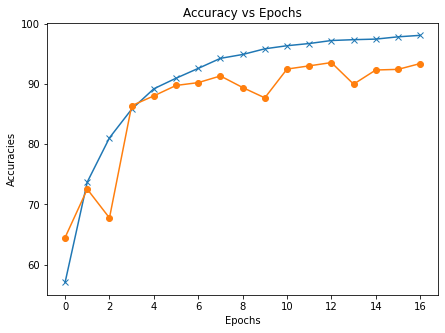

In [44]:
# plot metrics
plot_accuracy(train_accuracies, val_accuracies)

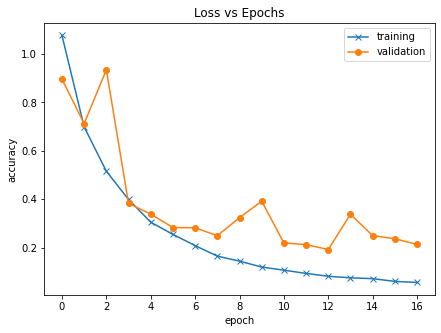

In [45]:
plot_losses(train_losses, val_losses)

In [46]:
# set up our test dataloader
test_dl = DeviceDataLoader(DataLoader(testset, batch_size*2), device)

# calculate test score
test_loss, test_score = evaluate(model_opt3_final, dataloader=test_dl, calc_loss=True)

print(f"Test Score: {test_score:.2f}% | Test Loss: {test_loss:.4f}")

Test Score: 83.96% | Test Loss: 0.5974


We see improvements compared to the previous version of this model, however it doesn't offer too much difference to be deemed an improvement. It seems like with all the tuning, our performance was not able to be better than what we had in the baseline. Perhaps our model was not as complex as we had thought, so the need for further regularization was not necessary. We saw in both early stopping and hyperparameter tuning that we were not able to outperform the baseline model. Let's see the confusion matrix of this model.

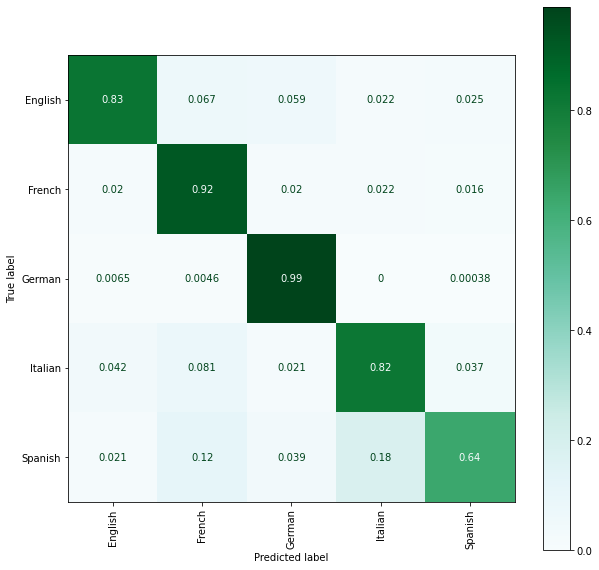

In [136]:
# Evaluate with the confusion matrix
generate_cm(model_opt3_final, test_dl)

This seems to be our best model in terms of getting the highest correct spanish classification. The English and Italian accuracy has in turn dropped off a bit. It seems like all our models are doing a sort of tug of war between these languages. I think if we want better accuracy we just need to put more data or bring a more complex model. However, I think having over 80% test accuracy for 5 classes is good enough for the sake of this project. We should also be considering how this AI will fair with external audio data from completely different data sets / sources.

<a id="conclusion"></a>
## Conclusion
It seems like the best models are the baseline model 3 with 20 epochs, and the Optimized Model 3 with early stopping at 17 epochs. We could have stopped Model 3 a bit earlier as well, however, it seems like our results are all capping at around 85% test score. 
I think this has been good enough in terms of explorating and optimizing, as we are getting minimum gains for the amount of time invested into this. I suggest that we save all of these models and test how they perform on a completely new dataset, scraped directly from the internet with never seem before audio.

In [28]:
# save the models
torch.save(model_3_final.state_dict(), "CNN_model_base.pt")
torch.save(model_opt2_final.state_dict(), "CNN_model_opt2.pt")
torch.save(model_opt3_final.state_dict(), "CNN_model_opt3.pt")

## to load example:
#new_model_3 = CNN_model_3(opt_fun=torch.optim.Adam, lr=0.0001, weight_decay=0.0001)
#new_model_3.load_state_dict(torch.load("<name>.pt"))
#new_model_3